Predicting Podcast Listening Time

Introduction

This project was featured on Kaggle in their monthly playground series. The problem statement was to predict the podcast listening time for various different based on different variables (features) like Genre, Episode Length, Publication Time, Publication Date, Number of Ads, etc.

Based on the features that are provided and the expected result, this is easily discernible as a Regression problem where a certain target is to be predicted based on the a given set of features.

Data Overview

Training Set: 750000 podcast episodes with features and the target (listening time)

Test Set: 250000 episodes without the target column (used for final prediction)

Key Features:

1. Categorical: Genre, Publication_Day, Publication_Time, Episode_Sentiment
2. Numerical: Episode_Length_minutes, Host_Popularity_percentage, Guest_Popularity_percentage, Number_of_Ads
3. Text: Podcast_Name, Episode_Title (not used directly in modeling)
4. Target: Listening_Time_minutes (train only)

Importing the required libraries & specifying the working directory -

In [5]:
import os
import pandas as pd
import numpy as np
from faiss_imputer import FaissImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
os.chdir(r"C:\Users\jadha\OneDrive\Desktop\MSBA\Personal Projects\Predicting Podcast Listening Time\playground-series-s5e4")
#data = pd.read_csv("train.csv")
#data.head()

In [33]:
#data.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146028
Number_of_Ads                       0
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

Data Preprocessing -

1. Missing Value Imputation: Used the Faiss Imputer (kNN-based) to fill missing values in Episode_Length_minutes and Guest_Popularity_percentage columns
2. EDA: Visualized distributions of key numeric features & checked for skewness
3. Encoding: Used Label Encoding for Episode_Sentiment & One-hot Encoding for categorical features (Genre, Publication_Day, Publication_Time, Number_of_Ads)

In [132]:
impute_columns = ['Episode_Length_minutes', 'Guest_Popularity_percentage']

In [133]:
imputer = FaissImputer(n_neighbors = 5)
#impute_values = imputer.fit_transform(data[impute_columns])

In [41]:
#imputed_df = pd.DataFrame(impute_values, columns = impute_columns, index = data.index)

In [43]:
#data[impute_columns] = imputed_df

In [49]:
#data.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

In [62]:
#data.to_csv('imputed_data.csv', index = False)

In [4]:
imp_data = pd.read_csv('imputed_data.csv')
imp_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,46.7125,True Crime,74.81,Thursday,Night,46.069996,0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.8000,Comedy,66.95,Saturday,Afternoon,75.950000,2,Negative,88.01241
2,2,Study Sessions,Episode 16,73.9000,Education,69.97,Tuesday,Evening,8.970000,0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.1700,Technology,57.22,Monday,Morning,78.700000,2,Positive,46.27824
4,4,Mind & Body,Episode 86,110.5100,Health,80.07,Monday,Afternoon,58.680000,3,Neutral,75.61031


Histograms of numeric features and Skewness check

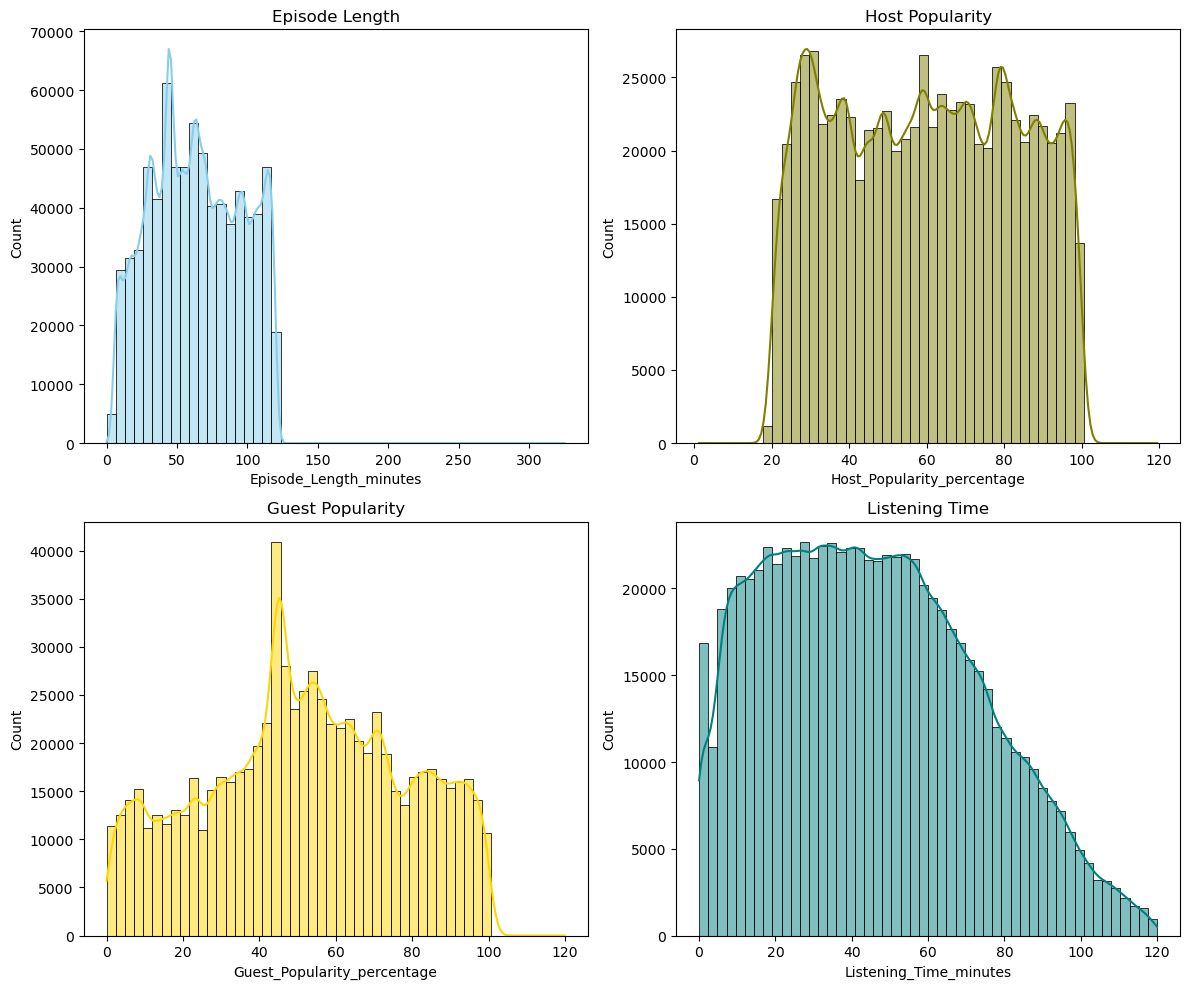

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
 
sns.histplot(imp_data['Episode_Length_minutes'], bins = 50, kde = True, color = 'skyblue', ax = axs[0, 0])
axs[0, 0].set_title('Episode Length')

sns.histplot(imp_data['Host_Popularity_percentage'], bins = 50, kde = True, color = 'olive', ax = axs[0, 1])
axs[0, 1].set_title('Host Popularity')

sns.histplot(imp_data['Guest_Popularity_percentage'], bins = 50, kde = True, color = 'gold', ax = axs[1, 0])
axs[1, 0].set_title('Guest Popularity')

sns.histplot(imp_data['Listening_Time_minutes'], bins = 50, kde = True, color = 'teal', ax = axs[1, 1])
axs[1, 1].set_title('Listening Time')

plt.tight_layout()
plt.show()

In [6]:
print(imp_data['Episode_Length_minutes'].skew())
print(imp_data['Host_Popularity_percentage'].skew())
print(imp_data['Guest_Popularity_percentage'].skew())
print(imp_data['Listening_Time_minutes'].skew())

0.04737815626840061
0.004913829268034986
-0.08982275382092025
0.3508021461592696


Label Encoding

In [175]:
le = LabelEncoder()
#imp_data['Episode_Sentiment_enc'] = le.fit_transform(imp_data['Episode_Sentiment'])

In [8]:
imp_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Sentiment_enc
0,0,Mystery Matters,Episode 98,46.7125,True Crime,74.81,Thursday,Night,46.069996,0,Positive,31.41998,2
1,1,Joke Junction,Episode 26,119.8000,Comedy,66.95,Saturday,Afternoon,75.950000,2,Negative,88.01241,0
2,2,Study Sessions,Episode 16,73.9000,Education,69.97,Tuesday,Evening,8.970000,0,Negative,44.92531,0
3,3,Digital Digest,Episode 45,67.1700,Technology,57.22,Monday,Morning,78.700000,2,Positive,46.27824,2
4,4,Mind & Body,Episode 86,110.5100,Health,80.07,Monday,Afternoon,58.680000,3,Neutral,75.61031,1


One-Hot Encoding

In [173]:
ohe_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Number_of_Ads']

In [174]:
ohe = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
#ohe_values = ohe.fit_transform(imp_data[ohe_cols])

In [22]:
imp_data_enc = pd.DataFrame(ohe_values, columns = ohe.get_feature_names_out(ohe_cols), index = imp_data.index)
pro_data = pd.concat([imp_data, imp_data_enc], axis = 1)

In [23]:
pro_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Number_of_Ads_0,Number_of_Ads_1,Number_of_Ads_2,Number_of_Ads_3,Number_of_Ads_12
0,0,Mystery Matters,Episode 98,46.7125,True Crime,74.81,Thursday,Night,46.069996,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1,Joke Junction,Episode 26,119.8000,Comedy,66.95,Saturday,Afternoon,75.950000,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,Study Sessions,Episode 16,73.9000,Education,69.97,Tuesday,Evening,8.970000,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,Digital Digest,Episode 45,67.1700,Technology,57.22,Monday,Morning,78.700000,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,Mind & Body,Episode 86,110.5100,Health,80.07,Monday,Afternoon,58.680000,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
#pro_data.to_csv('pro_data.csv')

In [18]:
#pro_data = pd.read_csv('pro_data.csv')
#pro_data.head()

Model Building -

1. Train-Test Split: Used the train_test_split function to create validation sets for model tuning.
2. Models Used:
   
   a. XGBoost Regressor: Tuned with early hyperparameter search and early stopping
   
   b. MLP Regressor: Neural network regressor with hyperparameter tuning via RandomizedSearchCV
   
   c. Random Forest Regressor: Strong baseline and the best individual model
   
   d. Simple Averaging Ensemble: Averaged all the three individual models
   
   e. Stacking Regressor: Combined all the three individual models with a RidgeCV meta-model

In [62]:
model_data = pro_data.copy()
model_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Number_of_Ads_0,Number_of_Ads_1,Number_of_Ads_2,Number_of_Ads_3,Number_of_Ads_12
0,0,Mystery Matters,Episode 98,46.7125,True Crime,74.81,Thursday,Night,46.069996,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1,Joke Junction,Episode 26,119.8000,Comedy,66.95,Saturday,Afternoon,75.950000,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,Study Sessions,Episode 16,73.9000,Education,69.97,Tuesday,Evening,8.970000,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,Digital Digest,Episode 45,67.1700,Technology,57.22,Monday,Morning,78.700000,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,Mind & Body,Episode 86,110.5100,Health,80.07,Monday,Afternoon,58.680000,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
red_cols = ['id', 'Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Episode_Sentiment', 'Publication_Time', 'Number_of_Ads', 'Listening_Time_minutes']

In [63]:
X = model_data.drop(red_cols, axis = 1)
y = model_data['Listening_Time_minutes']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 9)

1. XGBoost Regressor Model

In [54]:
param_grid = {'max_depth': np.arange(3, 8, 1),
    'learning_rate': np.arange(0.01, 0.21, 0.03),
    'n_estimators': 100,
    'subsample': np.arange(0.6, 1.1, 0.1),
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': np.arange(0, 0.6, 0.1)
             }

In [51]:
xgb = XGBRegressor(objective = 'reg:squarederror', random_state = 9)

In [ ]:
random_search_xgb = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = param_grid,
    n_iter = 30,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 2,
    random_state = 9
)

random_search_xgb.fit(X_train, y_train)

In [55]:
print("Best parameters: ", random_search_xgb.best_params_)

Best parameters:  {'subsample': 0.9999999999999999, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.13, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [78]:
xgb_best_model = random_search_xgb.best_estimator_
y_pred_xgb = xgb_best_model.predict(X_test)

In [80]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'MSE: {mse_xgb}, R^2: {r2_xgb}')

MSE: 178.0601999800861, R^2: 0.7579146033261708


Achieved a MSE = 178.06 & R² = 0.76 with the XGBoost Regressor Model

2. MLP Regressor Model

In [73]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,50), (100,20)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.01, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['adam'],
    'max_iter': [500, 1000]
}

In [74]:
mlp = MLPRegressor(random_state = 9)

In [75]:
random_search_mlp = RandomizedSearchCV(
    estimator = mlp,
    param_distributions = param_grid_mlp,
    n_iter = 10,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 2,
    random_state = 9
)

random_search_mlp.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=MLPRegressor(random_state=9), n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.01, 0.05],
                                        'hidden_layer_sizes': [(50, 50),
                                                               (100, 20)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'max_iter': [500, 1000],
                                        'solver': ['adam']},
                   random_state=9, scoring='neg_mean_squared_error', verbose=2)

In [76]:
print("Best parameters: ", random_search_mlp.best_params_)

Best parameters:  {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 20), 'alpha': 0.05, 'activation': 'relu'}


In [77]:
mlp_best_model = random_search_mlp.best_estimator_
y_pred_mlp = mlp_best_model.predict(X_test)

In [81]:
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f'MSE: {mse_mlp}, R^2: {r2_mlp}')

MSE: 186.19476042053816, R^2: 0.7468550948497437


Achieved a MSE = 186.19 & R² = 0.75 with the MLP Regressor Model

XGBoost Model outperforms the MLP Model by a small margin.

3. Random Forest Regressor Model

In [96]:
rf = RandomForestRegressor(random_state = 5)

Tuning the Random Forest Model

In [103]:
param_grid_rf = {
    'n_estimators': np.arange(100, 400, 100),
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 1.0]
}

In [107]:
random_search_rf = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid_rf,
    n_iter = 10,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 2,
    random_state = 9
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=5),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'max_features': ['sqrt', 'log2', 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([100, 200, 300])},
                   random_state=9, scoring='neg_mean_squared_error', verbose=2)

In [108]:
print("Best parameters: ", random_search_rf.best_params_)

Best parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 20}


In [109]:
rf_best_model = random_search_rf.best_estimator_
y_pred_rf_best = rf_best_model.predict(X_test)

In [110]:
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print(f"MSE: {mse_rf_best}")
print(f"R^2: {r2_rf_best}")

MSE: 173.0915731012088
R^2: 0.7646698018996407


Achieved a MSE = 173.09 & R² = 0.76 with the Random Forest Regressor Model

Random Forest outoerforms both XGB & MLP models by a small margin.

The next approach here would be to ensemble all the three models - XGB, MLP and tuned Random Forest to see if that produces

4. Simple Averaging Ensemble

In [111]:
y_pred_ensemble = (y_pred_rf + y_pred_xgb_final + y_pred_mlp) / 3

In [112]:
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)
print(f"Ensemble MSE: {mse_ensemble}")
print(f"Ensemble R^2: {r2_ensemble}")

Ensemble MSE: 173.83133681319447
Ensemble R^2: 0.7636640409733867


Achieved a MSE = 173.83 & R² = 0.76 with the Simple Averaging Ensemble

5. Stacking Regressor Model

This model uses a stacked ensemble of all the three individual models. This can potentially produce better results than any indivuidual model or the simple averaging ensemble. It often corrects for individual model biases & weaknesses, yielding modest but real improvements.

In [122]:
estimators = [('xgb', xgb_best_model), #Using the best_model instead of the final_model here due to lack of significant improvement
              ('mlp', mlp_best_model),
              ('rf', rf_best_model)]

In [115]:
meta_model = RidgeCV()

In [118]:
stacking_reg = StackingRegressor(
    estimators = estimators,
    final_estimator = meta_model,
    cv = 5,
    n_jobs = -1
)

stacking_reg.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=0.5,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_cons...
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('mlp',
                               MLPRegressor(alpha=0.05,
                                            hidden_layer_sizes=(100, 20),
                                            max_iter=1000, random_state=9)),
                              ('rf',
                               RandomForestRegressor(max_depth=20,
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     random_state=5))],
                  final_estimator=RidgeCV(), n_jobs=-1)

In [119]:
y_pred_stack = stacking_reg.predict(X_test)

In [121]:
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)
print(f"Stack MSE: {mse_stack}")
print(f"Stack R^2: {r2_stack}")

Stack MSE: 172.46430878069552
Stack R^2: 0.7655226119709975


Achieved a MSE = 172.46 & R² = 0.77 with the Stacking Regressor Model

Model Evaluation

Evaluating all the models built so far based on their corresponding MSE & R^2 values to determine the best one -

In [123]:
training_results = {
    'XGBoost': {
        'MSE': mse_xgb,
        'R^2': r2_xgb
    },
    'Random Forest': {
        'MSE': mse_rf_best,
        'R^2': r2_rf_best
    },
    'MLP Regressor': {
        'MSE': mse_mlp,
        'R^2': r2_mlp
    },
    'Simple Averaging Ensemble': {
        'MSE': mse_ensemble,
        'R^2': r2_ensemble
    },
    'Stacking Regressor': {
        'MSE': mse_stack,
        'R^2': r2_stack
    }
}

In [124]:
training_results_df = pd.DataFrame(training_results).T

In [125]:
training_results_df

,MSE,R^2
XGBoost,178.060200,0.757915
Random Forest,173.091573,0.764670
MLP Regressor,186.194760,0.746855
Simple Averaging Ensemble,173.831337,0.763664
Stacking Regressor,172.464309,0.765523


In [128]:
best_model_mse = training_results_df['MSE'].idxmin()
best_model_r2 = training_results_df['R^2'].idxmax()

In [129]:
print(f"\nBest model by MSE: {best_model_mse}")
print(f"\nBest model by R^2: {best_model_r2}")


Best model by MSE: Stacking Regressor

Best model by R^2: Stacking Regressor


We see that the Stacking Regressor Model outperformed all tha other models. Hence, this will be our model of choice for predicting the podcast listening times

Prediction & Scoring -

1. Preprocessed the provided test set almost identically to the training set (imputation, encoding and feature alignment)
2. Removed the outliers from the test set to match model expectations
3. Predicted Listening_Time_minutes using the best model (Stacking Regressor)
4. Exported the predictions in CSV format for submission and scoring

In [130]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [131]:
test_data.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

Imputation

In [136]:
impute_values_test = imputer.fit_transform(test_data[impute_columns])

C:\Users\jadha\anaconda3\Lib\site-packages\faiss_imputer\faiss_imputer.py:99: RuntimeWarning: Mean of empty slice
  column_agg = np.nanmean(selected_values, axis=0)


In [137]:
imputed_df_test = pd.DataFrame(impute_values_test, columns = impute_columns, index = test_data.index)

In [138]:
test_data[impute_columns] = imputed_df_test

In [140]:
test_data.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    5
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

There were 5 entries in the Guest_Popularity_percentage column which the Faiss Imputer was unable to impute. Those were imputed using the Simple Imputer from Scikit-learn

In [142]:
imputer_2 = SimpleImputer(strategy = 'median')
test_data['Guest_Popularity_percentage'] = imputer_2.fit_transform(test_data[['Guest_Popularity_percentage']])

In [143]:
test_data.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

All null values have been successfully imputed now & we can move on to encoding the categorical variables

Histogram of numeric features and Skewness check

In [157]:
print(test_data['Episode_Length_minutes'].skew())
print(test_data['Host_Popularity_percentage'].skew())
print(test_data['Guest_Popularity_percentage'].skew())

499.9999594922701
0.011749553531104412
-0.09162776


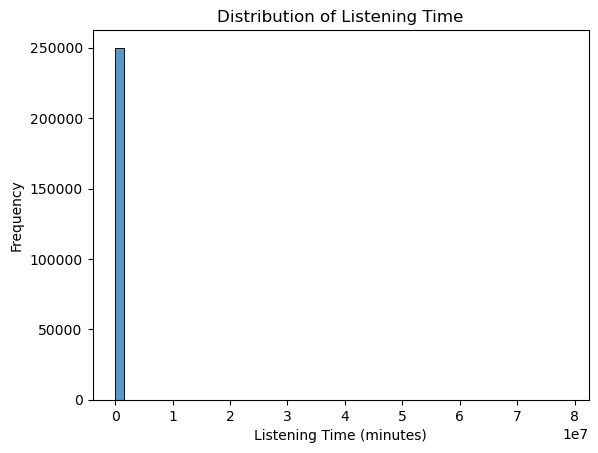

In [158]:
sns.histplot(data=test_data, x='Episode_Length_minutes', bins=50)
plt.title('Distribution of Listening Time')
plt.xlabel('Listening Time (minutes)')
plt.ylabel('Frequency')
plt.show()

There were some extreme outliers in the Episode Length column which skewed the data to such an extent

In [167]:
#test_data.to_csv('imputed_test.csv')

In [163]:
print(test_data['Episode_Length_minutes'].describe())

count    2.500000e+05
mean     3.809393e+02
std      1.569724e+05
min      2.470000e+00
25%      3.908750e+01
50%      6.652000e+01
75%      9.536000e+01
max      7.848626e+07
Name: Episode_Length_minutes, dtype: float64


In [164]:
extreme_values = test_data[test_data['Episode_Length_minutes'] > 1000]
print(extreme_values)

           id     Podcast_Name Episode_Title  Episode_Length_minutes  \
54434  804434  Current Affairs    Episode 36                  7575.0   
56597  806597   Market Masters    Episode 23              78486264.0   

          Genre  Host_Popularity_percentage Publication_Day Publication_Time  \
54434      News                       89.54        Saturday            Night   
56597  Business                       55.45          Monday          Evening   

       Guest_Popularity_percentage  Number_of_Ads Episode_Sentiment  
54434                    44.465645            2.0          Negative  
56597                    48.500000            0.0          Positive  


The two outliers have been identified and need to be removed from the dataset

In [165]:
outlier_values = [7575.0, 78486264.0]

In [166]:
test_data = test_data[~test_data['Episode_Length_minutes'].isin(outlier_values)]

In [169]:
test_data['Episode_Length_minutes'].describe()

count    249998.000000
mean         66.964525
std          33.246988
min           2.470000
25%          39.082501
50%          66.519997
75%          95.360001
max         190.129700
Name: Episode_Length_minutes, dtype: float64

In [171]:
print(test_data['Episode_Length_minutes'].skew())

0.0008759793661870074


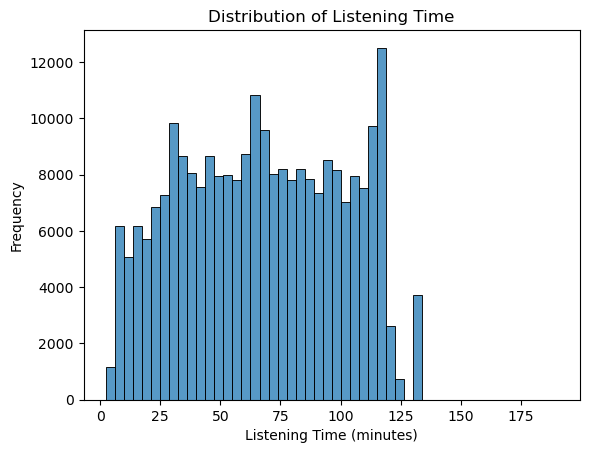

In [170]:
sns.histplot(data=test_data, x='Episode_Length_minutes', bins=50)
plt.title('Distribution of Listening Time')
plt.xlabel('Listening Time (minutes)')
plt.ylabel('Frequency')
plt.show()

The two outlier entries were dealt with & the dataset was made ready for encoding

Label Encoding

In [177]:
test_data.loc[:, 'Episode_Sentiment_enc'] = le.fit_transform(test_data['Episode_Sentiment'])

In [185]:
#test_data.to_csv('imp_test_data.csv')

In [200]:
imp_test_data = pd.read_csv('imp_test_data.csv')

One-Hot Encoding

In [201]:
ohe_values_test = ohe.fit_transform(imp_test_data[ohe_cols])

In [202]:
test_data_enc = pd.DataFrame(ohe_values_test, columns = ohe.get_feature_names_out(ohe_cols), index = imp_test_data.index)
pro_test_data = pd.concat([imp_test_data, test_data_enc], axis = 1)

In [203]:
pro_test_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Number_of_Ads_0,Number_of_Ads_1,Number_of_Ads_2,Number_of_Ads_3,Number_of_Ads_12
0,750000,Educational Nuggets,Episode 73,78.959999,Education,38.11,Saturday,Evening,53.3300,12,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,750001,Sound Waves,Episode 23,27.870001,Music,71.29,Sunday,Morning,60.6875,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,750002,Joke Junction,Episode 11,69.099998,Comedy,67.89,Friday,Evening,97.5100,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,750003,Comedy Corner,Episode 73,115.389999,Comedy,23.40,Sunday,Morning,51.7500,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,750004,Life Lessons,Episode 50,72.320000,Lifestyle,58.10,Wednesday,Morning,11.3000,2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [195]:
#pro_test_data.to_csv('pro_test_data.csv')

Dropping all the redundant colums from the dataset

In [204]:
red_cols_test = ['id', 'Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Episode_Sentiment', 'Publication_Time', 'Number_of_Ads']

In [205]:
final_test_data = pro_test_data.drop(columns = red_cols_test)

In [206]:
final_test_data.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Episode_Sentiment_enc,Genre_Business,Genre_Comedy,Genre_Education,Genre_Health,Genre_Lifestyle,Genre_Music,...,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Number_of_Ads_0,Number_of_Ads_1,Number_of_Ads_2,Number_of_Ads_3,Number_of_Ads_12
0,78.959999,38.11,53.3300,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,27.870001,71.29,60.6875,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,69.099998,67.89,97.5100,2,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,115.389999,23.40,51.7500,2,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,72.320000,58.10,11.3000,1,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


All the preprocessing is now done on the test data set & it can now be fitted with the Stacking Regressor model to obtain the predictions

Obtaining the predictions

In [207]:
y_pred_final = stacking_reg.predict(final_test_data)

In [214]:
final_test_data['Predicted_Listening_Time'] = y_pred_final

In [215]:
final_test_data.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Episode_Sentiment_enc,Genre_Business,Genre_Comedy,Genre_Education,Genre_Health,Genre_Lifestyle,Genre_Music,...,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Number_of_Ads_0,Number_of_Ads_1,Number_of_Ads_2,Number_of_Ads_3,Number_of_Ads_12,Predicted_Listening_Time
0,78.959999,38.11,53.3300,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.255931
1,27.870001,71.29,60.6875,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,19.351636
2,69.099998,67.89,97.5100,2,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.758756
3,115.389999,23.40,51.7500,2,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,75.618803
4,72.320000,58.10,11.3000,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,45.306038


In [219]:
final_test_data.to_csv('final_test_data.csv')

This concludes the project!

I was able to achieve a RMSE of 34.49 through this model. It's not the best or ideal score but given the amount of time it took me to build this project & the hardware that was available, it's a good score

Deep Hyperparameter tuning resources & advanced feature engineering knowledge is needed to further improve the RMSE